In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

# TA-Lib for indicators
import talib

# PyNance and PyFolio will be used later, we just import them now
import talib                      # technical indicators
import pynance as py              # from GitHub version
import quantstats as qs   

# Make plots a bit nicer
plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = (12, 6)


## Load or download a data (META)

In [2]:
# ============================================
# Download META daily data for a year
# ============================================

ticker = "META"
start_date = "2009-01-01"
end_date   = "2023-12-29"

df = yf.download(ticker, start=start_date, end=end_date, progress=False) 
df.head()


C:\Users\Birhanu Matebe\AppData\Local\Temp\ipykernel_16148\2049888926.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)


Price,Close,High,Low,Open,Volume
Ticker,META,META,META,META,META
Date,,,,,
2012-05-18,37.995770,44.724291,37.767179,41.792365,573576400
2012-05-21,33.821499,36.435386,32.797811,36.306182,168192700
2012-05-22,30.810064,33.384196,30.750432,32.410201,101786600
2012-05-23,31.803938,32.300874,31.167860,31.177799,73600000
2012-05-24,32.827625,33.006523,31.575347,32.748117,50237200


# 1. Data profiling

In [3]:
# ============================================
# Clean the columns (handle MultiIndex case)
# ============================================

# If columns are MultiIndex (like: ('Close', 'AMZN')), flatten them
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)  # keep only first level: Open, High, etc.

print("Cleaned columns:", df.columns.tolist())

# Optional: add a Ticker column (useful if using multiple tickers later)
df["Ticker"] = ticker

# Ensure index is datetime and sorted
df.index = pd.to_datetime(df.index)
df = df.sort_index()




Cleaned columns: ['Close', 'High', 'Low', 'Open', 'Volume']


# - Summary Statistics 

In [4]:
# log the shape of dataset and the first five rows of dataset
print(f'the shape of META dataset ${df.shape}')
df.head()

the shape of META dataset $(2922, 6)


Price,Close,High,Low,Open,Volume,Ticker
Date,,,,,,
2012-05-18,37.995770,44.724291,37.767179,41.792365,573576400,META
2012-05-21,33.821499,36.435386,32.797811,36.306182,168192700,META
2012-05-22,30.810064,33.384196,30.750432,32.410201,101786600,META
2012-05-23,31.803938,32.300874,31.167860,31.177799,73600000,META
2012-05-24,32.827625,33.006523,31.575347,32.748117,50237200,META


In [5]:
# log the last examples of this dataset
df.tail()

Price,Close,High,Low,Open,Volume,Ticker
Date,,,,,,
2023-12-21,351.920502,354.226294,347.070396,350.817317,15289600,META
2023-12-22,351.224792,355.011446,349.068075,353.401346,11772800,META
2023-12-26,352.655945,354.792796,351.284426,352.814968,9898600,META
2023-12-27,355.637604,356.800449,353.133054,353.888408,13207900,META
2023-12-28,356.124603,359.682655,355.617718,357.496153,11798800,META


In [6]:
# log the last examples of this dataset
df.sample(5)

Price,Close,High,Low,Open,Volume,Ticker
Date,,,,,,
2017-08-17,165.887375,168.819298,165.827745,168.302479,17216000,META
2013-03-11,27.967588,28.464525,27.659488,27.838386,35642100,META
2018-05-16,182.077515,183.190663,181.540830,182.574451,16975500,META
2014-11-05,74.371521,76.329452,73.964029,76.041228,35913000,META
2022-05-26,190.455902,191.648547,181.143301,181.759513,23056500,META


In [7]:
# check more information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2922 entries, 2012-05-18 to 2023-12-28
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2922 non-null   float64
 1   High    2922 non-null   float64
 2   Low     2922 non-null   float64
 3   Open    2922 non-null   float64
 4   Volume  2922 non-null   int64  
 5   Ticker  2922 non-null   object 
dtypes: float64(4), int64(1), object(1)
memory usage: 159.8+ KB


In [8]:
# check if a null value exists
print("Check for missing values:")
df.isna().sum()

Check for missing values:


Price
Close     0
High      0
Low       0
Open      0
Volume    0
Ticker    0
dtype: int64

In [9]:
# 1. Calculate the percentage of missing values for every column
null_percentages = df.isnull().sum() / len(df) * 100

# 2. Filter the resulting Series for percentages greater than 5
columns_with_high_nulls = null_percentages[null_percentages > 5]

# 3. Print the results
print("Columns with >5% Null Values:")
print(columns_with_high_nulls)

Columns with >5% Null Values:
Series([], dtype: float64)


In [10]:
# Check if null rows exist
# 1. Define the critical columns
key_cols = ['Close', 'Open', 'High', 'Volume', 'Ticker']

# 2. Create a boolean mask:
missing_rows_mask = df[key_cols].isnull().any(axis=1)

# 3. Use the mask to display the subset of rows with missing data
missing_value_rows = df[missing_rows_mask]

# 4. Display the resulting DataFrame
print(f"Total rows with missing values in the key columns: {len(missing_value_rows)}")
print("Rows with Missing Data (only showing the key columns for focus):")
print(missing_value_rows[key_cols])

Total rows with missing values in the key columns: 0
Rows with Missing Data (only showing the key columns for focus):
Empty DataFrame
Columns: [Close, Open, High, Volume, Ticker]
Index: []


In [11]:
# log statistical data values
print("The description of the numeric columns:")
print(df.describe())

The description of the numeric columns:


Price        Close         High          Low         Open        Volume
count  2922.000000  2922.000000  2922.000000  2922.000000  2.922000e+03
mean    156.660683   158.622345   154.618370   156.585133  3.061150e+07
std      90.312119    91.412165    89.165274    90.248325  2.637450e+07
min      17.621367    18.158059    17.442469    17.969222  5.467500e+06
25%      80.275124    80.950961    79.651468    80.260215  1.635358e+07
50%     152.569458   154.626767   150.720847   152.678781  2.295815e+07
75%     203.478119   206.283323   200.474151   202.924047  3.522885e+07
max     379.838379   381.975227   376.489059   379.341462  5.735764e+08


In [12]:
#Overview of categorical columns
print("The description of the categorical columns:")
print(df.describe(include=['object']))

The description of the categorical columns:
Price  Ticker
count    2922
unique      1
top      META
freq     2922


In [13]:
# log and check the frequency, and uniqueness of all dataset column
print("The description of all columns:")
print(df.describe(include='all'))


The description of all columns:
Price         Close         High          Low         Open        Volume  \
count   2922.000000  2922.000000  2922.000000  2922.000000  2.922000e+03   
unique          NaN          NaN          NaN          NaN           NaN   
top             NaN          NaN          NaN          NaN           NaN   
freq            NaN          NaN          NaN          NaN           NaN   
mean     156.660683   158.622345   154.618370   156.585133  3.061150e+07   
std       90.312119    91.412165    89.165274    90.248325  2.637450e+07   
min       17.621367    18.158059    17.442469    17.969222  5.467500e+06   
25%       80.275124    80.950961    79.651468    80.260215  1.635358e+07   
50%      152.569458   154.626767   150.720847   152.678781  2.295815e+07   
75%      203.478119   206.283323   200.474151   202.924047  3.522885e+07   
max      379.838379   381.975227   376.489059   379.341462  5.735764e+08   

Price  Ticker  
count    2922  
unique      1  
top    

In [14]:
#check if duplication of rows exist
dup_count = df.duplicated().sum()
print("Duplicate rows:", dup_count)

Duplicate rows: 0


In [15]:
# Cardinality (uniqueness) for categoricals
cat_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
cardinality = {c: df[c].nunique() for c in cat_cols}
print("Cardinality (categoricals):", cardinality)

Cardinality (categoricals): {'Ticker': 1}


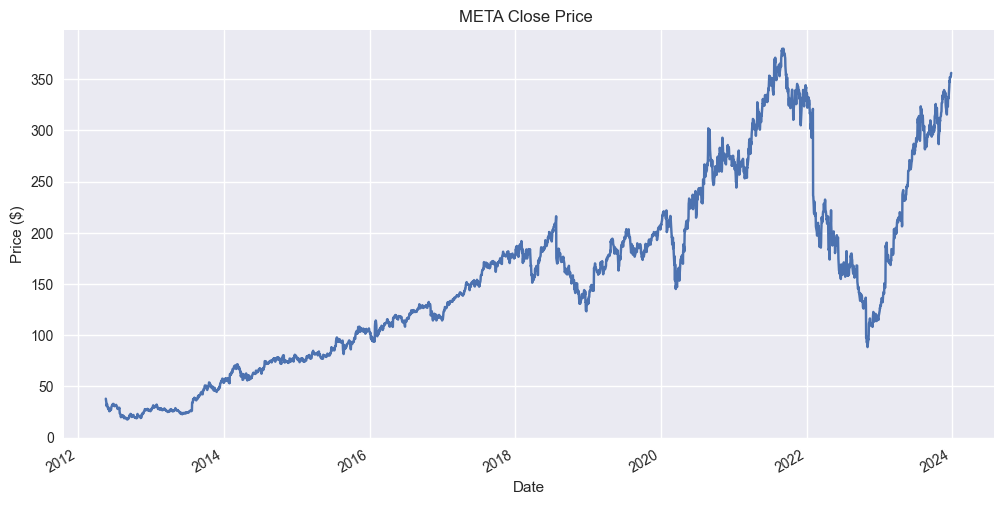

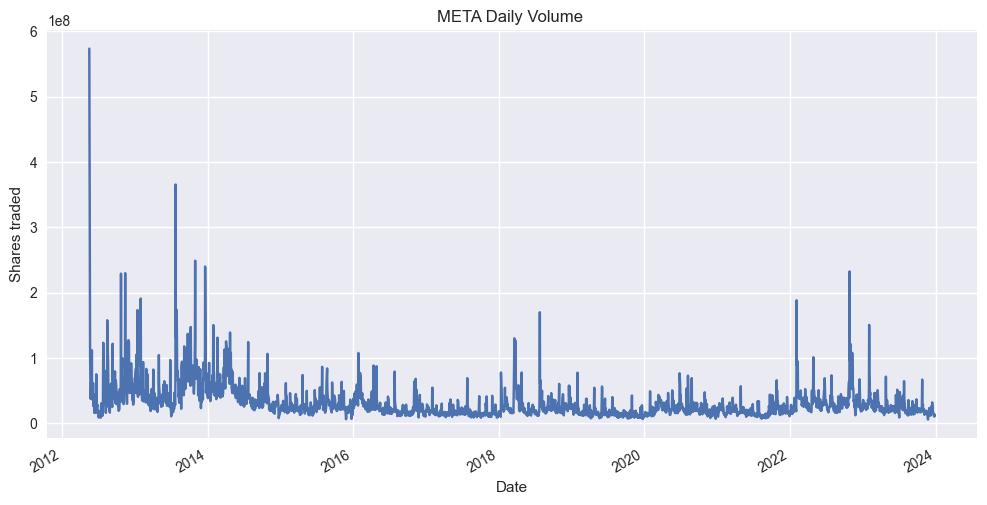

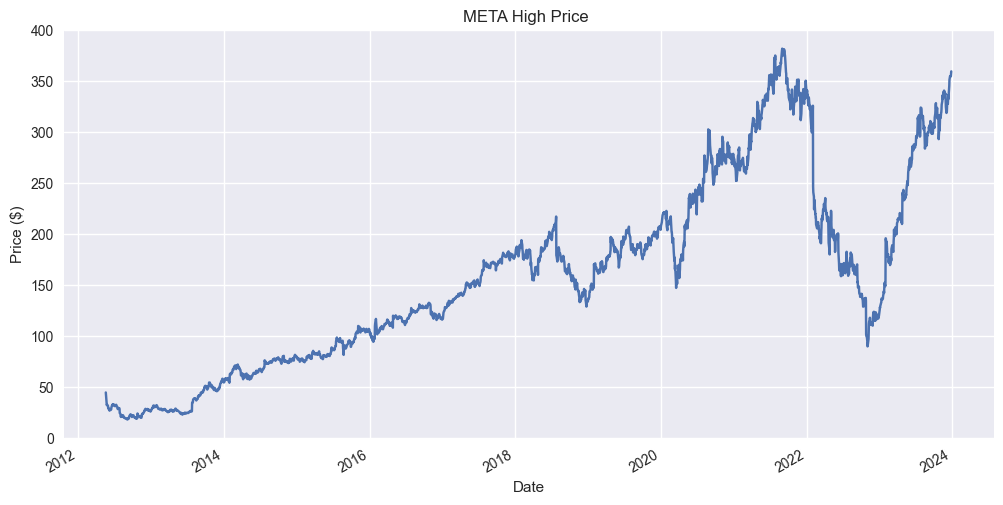

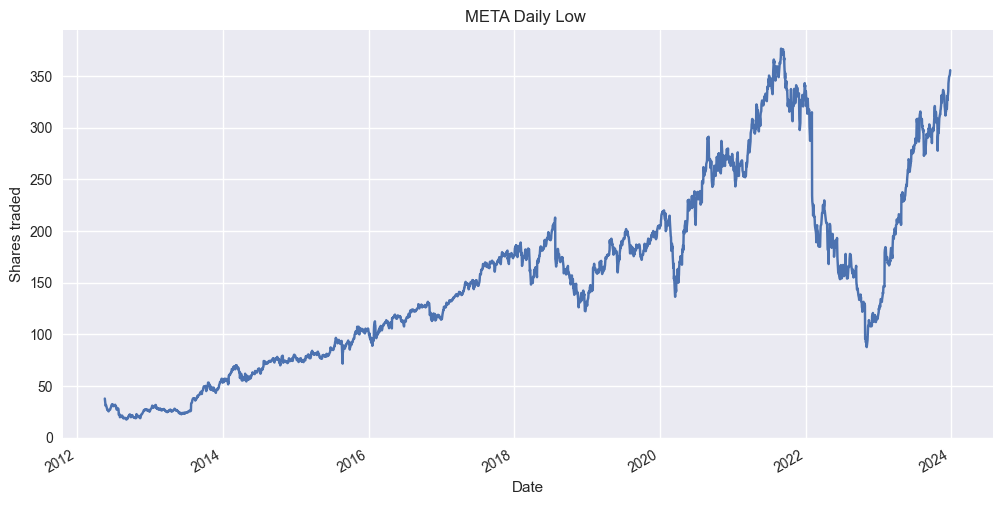

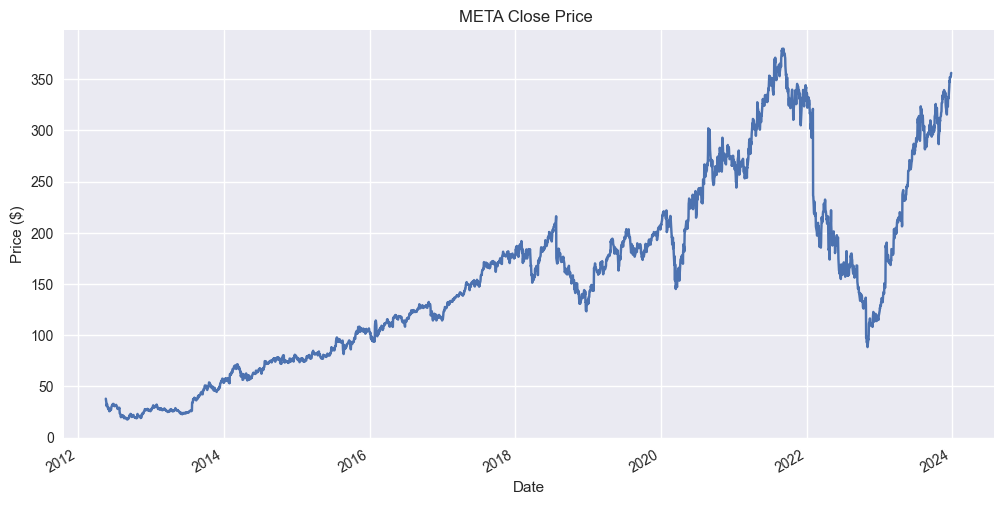

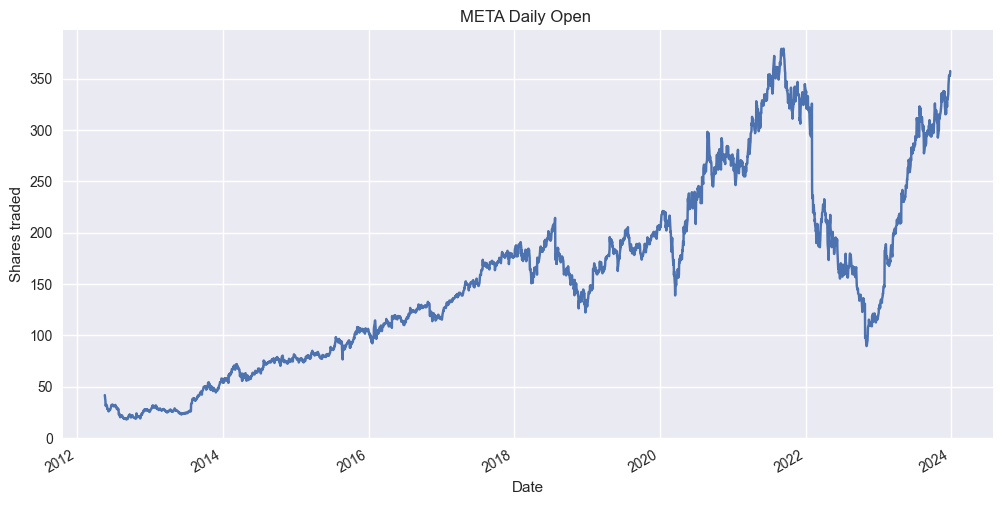

In [16]:
# ============================================
# Quick look at price and volume
# ============================================

# Close price chart
df["Close"].plot(title="META Close Price ")
plt.ylabel("Price ($)")
plt.show()

# Volume chart
df["Volume"].plot(title="META Daily Volume ")
plt.ylabel("Shares traded")
plt.show()
df["High"].plot(title="META High Price ")
plt.ylabel("Price ($)")
plt.show()

# Volume chart
df["Low"].plot(title="META Daily Low ")
plt.ylabel("Shares traded")
plt.show()
df["Close"].plot(title="META Close Price ")
plt.ylabel("Price ($)")
plt.show()

# Volume chart
df["Open"].plot(title="META Daily Open ")
plt.ylabel("Shares traded")
plt.show()


## Stock price over time

## Interpretation of Meta Platforms (META) Price History (2012–2024)
1. Long-Term Trend: High-Growth, High-Volatility
- The overall trajectory from the 2012 IPO price (around $25-$40) to the current price (around $350) represents phenomenal long-term growth. However, this growth has been interrupted by severe and rapid price swings.

2. Key Phases of Price Movement
- 2012 – 2021: Aggressive, Volatile Ascent: After stabilizing from its initial IPO volatility, the stock settled into a strong uptrend driven by the dominance of its social media platforms (Facebook, Instagram, WhatsApp). This period is marked by several significant, sharp dips (e.g., 2018-2019) that were quickly recovered. The price peaked near $380 in mid-2021.

- Late 2021 – Late 2022: The "Triple Whammy" Crash: This is the most dramatic phase of the chart. The stock suffered a catastrophic bear market correction, falling from $380 to a low around $88. This massive decline was driven by:

- Slowdown in Core Business: Deceleration of user growth and pressure on ad revenue.

- Increased Competition: Challenges from rivals like TikTok.

- The Metaverse Bet: Massive investor skepticism and high capital expenditure on the transition to the "Metaverse," which raised concerns about profitability.

- 2023 – Early 2024: Record Recovery: The stock staged one of the most remarkable comebacks in recent market history. The price more than quadrupled from its 2022 low, soaring back above $350. This recovery was fueled by:

- "Year of Efficiency": Aggressive cost-cutting and layoffs.

- Improved Core Business: Rebounding ad revenue and better monetization of its platforms.

- AI Integration: Strong performance and future potential in integrating AI across its products.

3. Volatility Profile
- Meta's chart highlights the extreme volatility associated with high-growth, platform-dependent tech companies. The stock delivered immense returns but required investors to endure two different periods of 40%+ drawdowns before the final, cataclysmic 77% crash in 2022. The 2023 recovery is equally dramatic, showing that when investor confidence returns, the price can move explosively fast.

In [17]:
# ============================================
# Compute technical indicators with TA-Lib
# ============================================

# Use 'Adj Close' if available, otherwise 'Close'
if "Adj Close" in df.columns:
    price = df["Adj Close"]
else:
    price = df["Close"]

# --- Moving Averages ---
df["SMA_20"] = talib.SMA(price, timeperiod=20)
df["SMA_50"] = talib.SMA(price, timeperiod=50)
df["EMA_20"] = talib.EMA(price, timeperiod=20)

# --- RSI ---
df["RSI_14"] = talib.RSI(price, timeperiod=14)

# --- MACD ---
df["MACD"], df["MACD_signal"], df["MACD_hist"] = talib.MACD(
    price, fastperiod=12, slowperiod=26, signalperiod=9
)


df.tail()


Price,Close,High,Low,Open,Volume,Ticker,SMA_20,SMA_50,EMA_20,RSI_14,MACD,MACD_signal,MACD_hist
Date,,,,,,,,,,,,,
2023-12-21,351.920502,354.226294,347.070396,350.817317,15289600,META,331.549593,322.736820,333.935059,68.158911,6.362816,4.176044,2.186772
2023-12-22,351.224792,355.011446,349.068075,353.401346,11772800,META,332.302946,323.317839,335.581701,67.333857,6.945366,4.729908,2.215457
2023-12-26,352.655945,354.792796,351.284426,352.814968,9898600,META,333.303278,324.115718,337.207819,68.186972,7.436796,5.271286,2.165510
2023-12-27,355.637604,356.800449,353.133054,353.888408,13207900,META,334.239505,324.844824,338.963037,69.947898,7.974923,5.812013,2.162910
2023-12-28,356.124603,359.682655,355.617718,357.496153,11798800,META,335.537503,325.527019,340.597472,70.237671,8.344499,6.318510,2.025989


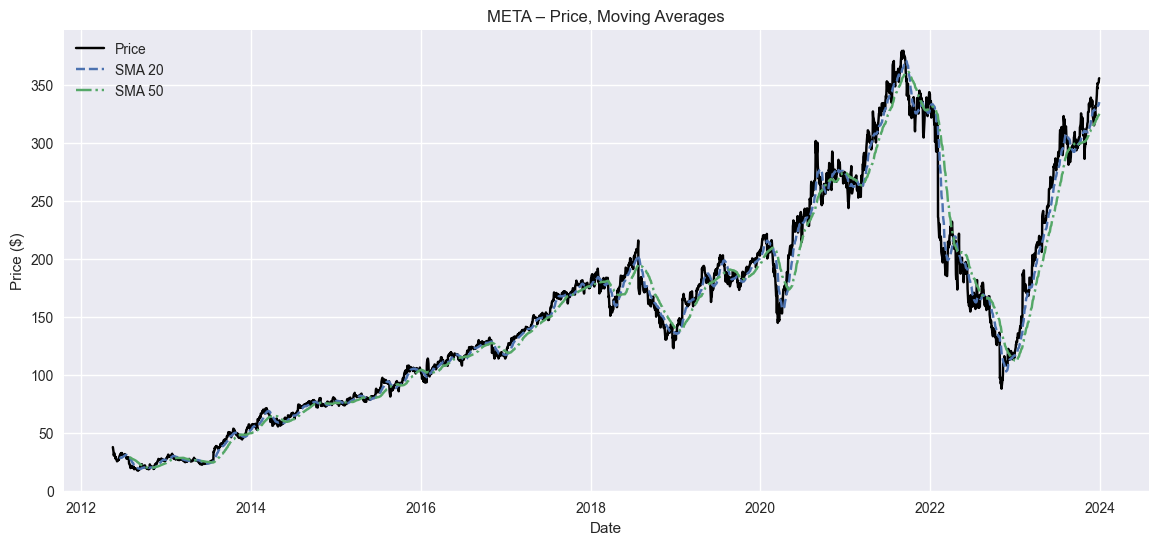

In [18]:
# ============================================
# Price + SMA + Bollinger Bands
# ============================================

fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(df.index, price, label="Price", color="black")
ax.plot(df.index, df["SMA_20"], label="SMA 20", linestyle="--")
ax.plot(df.index, df["SMA_50"], label="SMA 50", linestyle="-.")


ax.set_title("META – Price, Moving Averages")
ax.set_xlabel("Date")
ax.set_ylabel("Price ($)")
ax.legend()
plt.show()


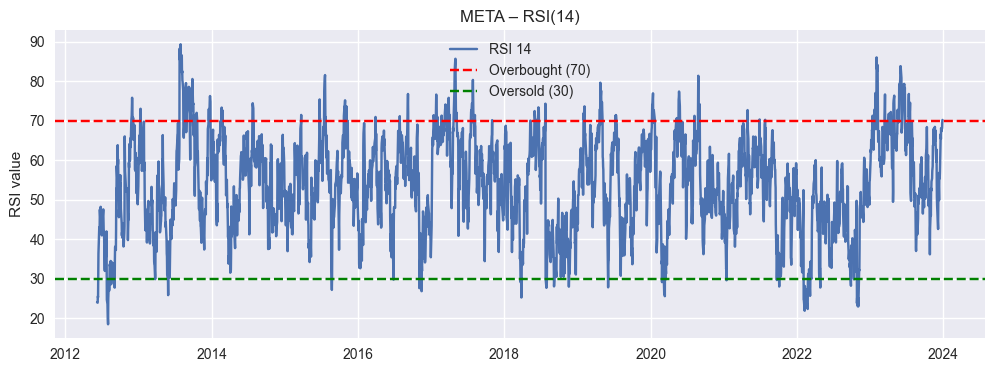

In [19]:
# ============================================
# RSI – Overbought / Oversold
# ============================================

fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(df.index, df["RSI_14"], label="RSI 14")
ax.axhline(70, color="red", linestyle="--", label="Overbought (70)")
ax.axhline(30, color="green", linestyle="--", label="Oversold (30)")

ax.set_title("META – RSI(14)")
ax.set_ylabel("RSI value")
ax.legend()
plt.show()


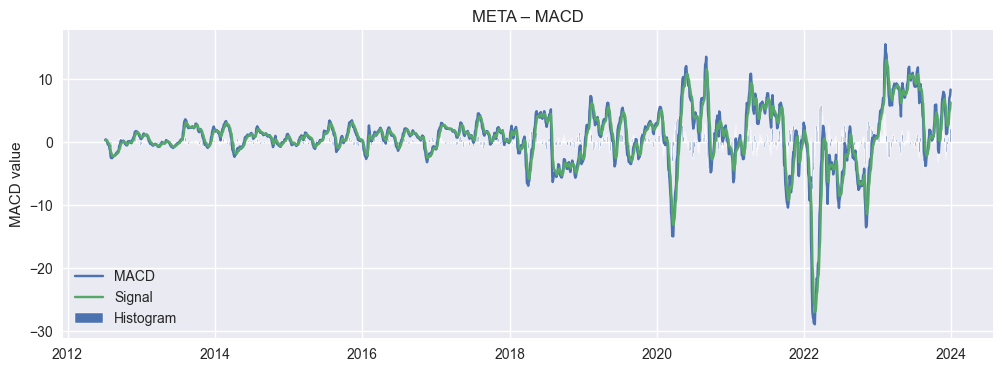

In [20]:
# ============================================
# MACD – Trend & momentum
# ============================================

fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(df.index, df["MACD"], label="MACD")
ax.plot(df.index, df["MACD_signal"], label="Signal")
ax.bar(df.index, df["MACD_hist"], label="Histogram")

ax.set_title("META – MACD")
ax.set_ylabel("MACD value")
ax.legend()
plt.show()


## Interpretation of Meta Platforms (META) MACD
- The MACD (12, 26, 9) measures the momentum of Meta's closing price. This chart is defined by two extreme conditions: extended periods of strong positive momentum, followed by a sudden, catastrophic shift to extreme negative momentum, and then a quick recovery.

1. The Long-Term Bull Trend (2012–2021)
- Sustained Positive Momentum: For the majority of the period up to 2021, the MACD Line and Signal Line were consistently positioned above the Zero Line. This confirms a strong, healthy uptrend where short-term momentum was continuously faster than medium-term momentum.

- Minor Dips: While the MACD occasionally dipped toward the zero line during pullbacks, it always quickly rebounded, reinforcing the overall bullish bias.

2. The Defining 2022 Momentum Collapse 
- This phase is the most visually dramatic part of the chart and confirms the severity of the stock's correction:

- Massive Plunge Below Zero: In late 2021/early 2022, the MACD Line plunged sharply and deeply below the Zero Line, reaching extreme negative values. This signaled a fundamental and catastrophic loss of positive momentum.

- Significance: The depth and length of time the MACD remained in deep negative territory (especially from late 2022 to early 2023) technically confirmed the existence of a severe bear market. The momentum breakdown was caused by a slowdown in user growth, competition from TikTok, and huge capital expenditure on the Metaverse, which led to lower-than-expected earnings and profits. The market cap saw the biggest one-day loss in US stock history at the time.

3. The 2023 Momentum Recovery 
- Aggressive Crossover and Return to Positive: The stock's massive recovery in 2023 is heralded by a sharp and decisive MACD crossover (MACD Line above Signal Line) followed by the entire formation moving back above the Zero Line.

- Significance: This signaled the forceful return of positive momentum, driven by investor confidence in Meta's "Year of Efficiency" (cost-cutting), rebounding ad revenue, and focus on AI.

## Interpretation of Meta Platforms (META) Relative Strength Index (RSI 14)
- The RSI (14) measures the speed and change of META's closing price movements and highlights how momentum shifted during the company's major events.

1. High Amplitude Oscillations
- The most notable feature is the high amplitude of the RSI line's movement. It swings frequently and dramatically, confirming that Meta's closing price is subject to periods of extreme positive momentum followed by sharp corrections. This reflects the volatility inherent in a platform-based company where sentiment shifts quickly.

2. Overbought Signals (RSI > 70) 
- The RSI line regularly crosses the 70 (Overbought) threshold. This was especially frequent during the long rally phase (2012–2021) and the powerful recovery of 2023-2024.

- Significance: In a fast-moving growth stock like META, these readings signal intense, high-conviction buying and rapidly accelerating upward momentum.

3. Critical: Deep and Sustained Oversold Period (RSI < 30) 
- The RSI line confirms the technical breakdown of the 2022 period. It plunged sharply below the 30 (Oversold) line and spent a significant amount of time in deep oversold territory.

- Significance: This extreme oversold condition confirms the severity and the high-conviction fear that drove the closing price collapse (a 77% drawdown from peak). Such a sustained low RSI reading is a technical sign of panic selling.

- High-Conviction Buying: The eventual snap-back from this extreme low, which marked the start of the 2023 recovery, provided a textbook example of an excellent, deep-value entry point for long-term buyers.

## Interpretation of Meta Platforms (META) MACD
- The MACD (12, 26, 9) measures the momentum of Meta's closing price. This chart is defined by two extreme conditions: extended periods of strong positive momentum, followed by a sudden, catastrophic shift to extreme negative momentum, and then a quick recovery.

1. The Long-Term Bull Trend (2012–2021)
- Sustained Positive Momentum: For the majority of the period up to 2021, the MACD Line and Signal Line were consistently positioned above the Zero Line. This confirms a strong, healthy uptrend where short-term momentum was continuously faster than medium-term momentum.

- Minor Dips: While the MACD occasionally dipped toward the zero line during pullbacks, it always quickly rebounded, reinforcing the overall bullish bias.

2. The Defining 2022 Momentum Collapse 
- This phase is the most visually dramatic part of the chart and confirms the severity of the stock's correction:

- Massive Plunge Below Zero: In late 2021/early 2022, the MACD Line plunged sharply and deeply below the Zero Line, reaching extreme negative values (approaching -30). This signaled a fundamental and catastrophic loss of positive momentum.

- Significance: The depth and length of time the MACD remained in deep negative territory technically confirmed the existence of a severe bear market. The momentum breakdown was caused by factors like high capital expenditure on the Metaverse, decelerating user growth, and concerns over profitability.

3. The 2023 Momentum Recovery 

- Aggressive Crossover and Return to Positive: The stock's massive recovery in 2023 is heralded by a sharp and decisive MACD crossover (MACD Line above Signal Line) followed by the entire formation moving back above the Zero Line.

- Significance: This signaled the forceful restoration of positive momentum, driven by investor confidence in cost-cutting ("Year of Efficiency") and rebounding core ad business performance.